In [84]:
import torch
from transformers import GPT2Model, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt

def analyze_activation_norms(text_samples, layer_num=6):
    """ 
    text_samples : List of sentences
    layer_num : Integer from 0 to 12 which is the number of layers
    """
    model = GPT2Model.from_pretrained('gpt2')
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Dictionary to store norms and tokens for each sentence
    sentence_data = {i: {'norms': [], 'tokens': []} for i in range(len(text_samples))}
    model.eval()
    with torch.no_grad():
        for idx, text in enumerate(text_samples):
            # Tokenize single sentence
            inputs = tokenizer(text, return_tensors="pt")
            
            # Get model outputs with output_hidden_states=True
            outputs = model(**inputs, output_hidden_states=True)
            
            
            # Get activations from specified layer
            
            layer_activations = outputs.hidden_states[layer_num + 1]  # +1 because first element is embedding
            
            # Calculate norms
            mean_activation = torch.mean(layer_activations, dim=-1, keepdim=True)
            centered_activations = layer_activations - mean_activation
            norms = torch.norm(centered_activations, dim=-1)[0]  # [0] to remove batch dimension
            
            
            # Store results
            sentence_data[idx]['norms'] = norms.cpu().numpy()
            sentence_data[idx]['tokens'] = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Create visualization
    num_sentences = len(text_samples)
    fig, axes = plt.subplots(num_sentences, 1, figsize=(15, 5*num_sentences))
    if num_sentences == 1:
        axes = [axes]
    
    for idx, (sentence, data) in enumerate(sentence_data.items()):
        ax = axes[idx]
        norms = data['norms']
        tokens = data['tokens']
        
        # Bar plot of norms
        bars = ax.bar(range(len(tokens)), norms)
        
        ax.set_title(f'Sentence {idx + 1}: "{text_samples[idx][:50]}..."')
        ax.set_xlabel('Token')
        ax.set_ylabel('Centered Activation Norm')
        
        ax.set_xticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=45, ha='right')
        
        mean_norm = np.mean(norms)
        ax.axhline(y=mean_norm, color='r', linestyle='--', 
                  label=f'Centered Mean Norm: {mean_norm:.2f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return sentence_data

/opt/homebrew/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


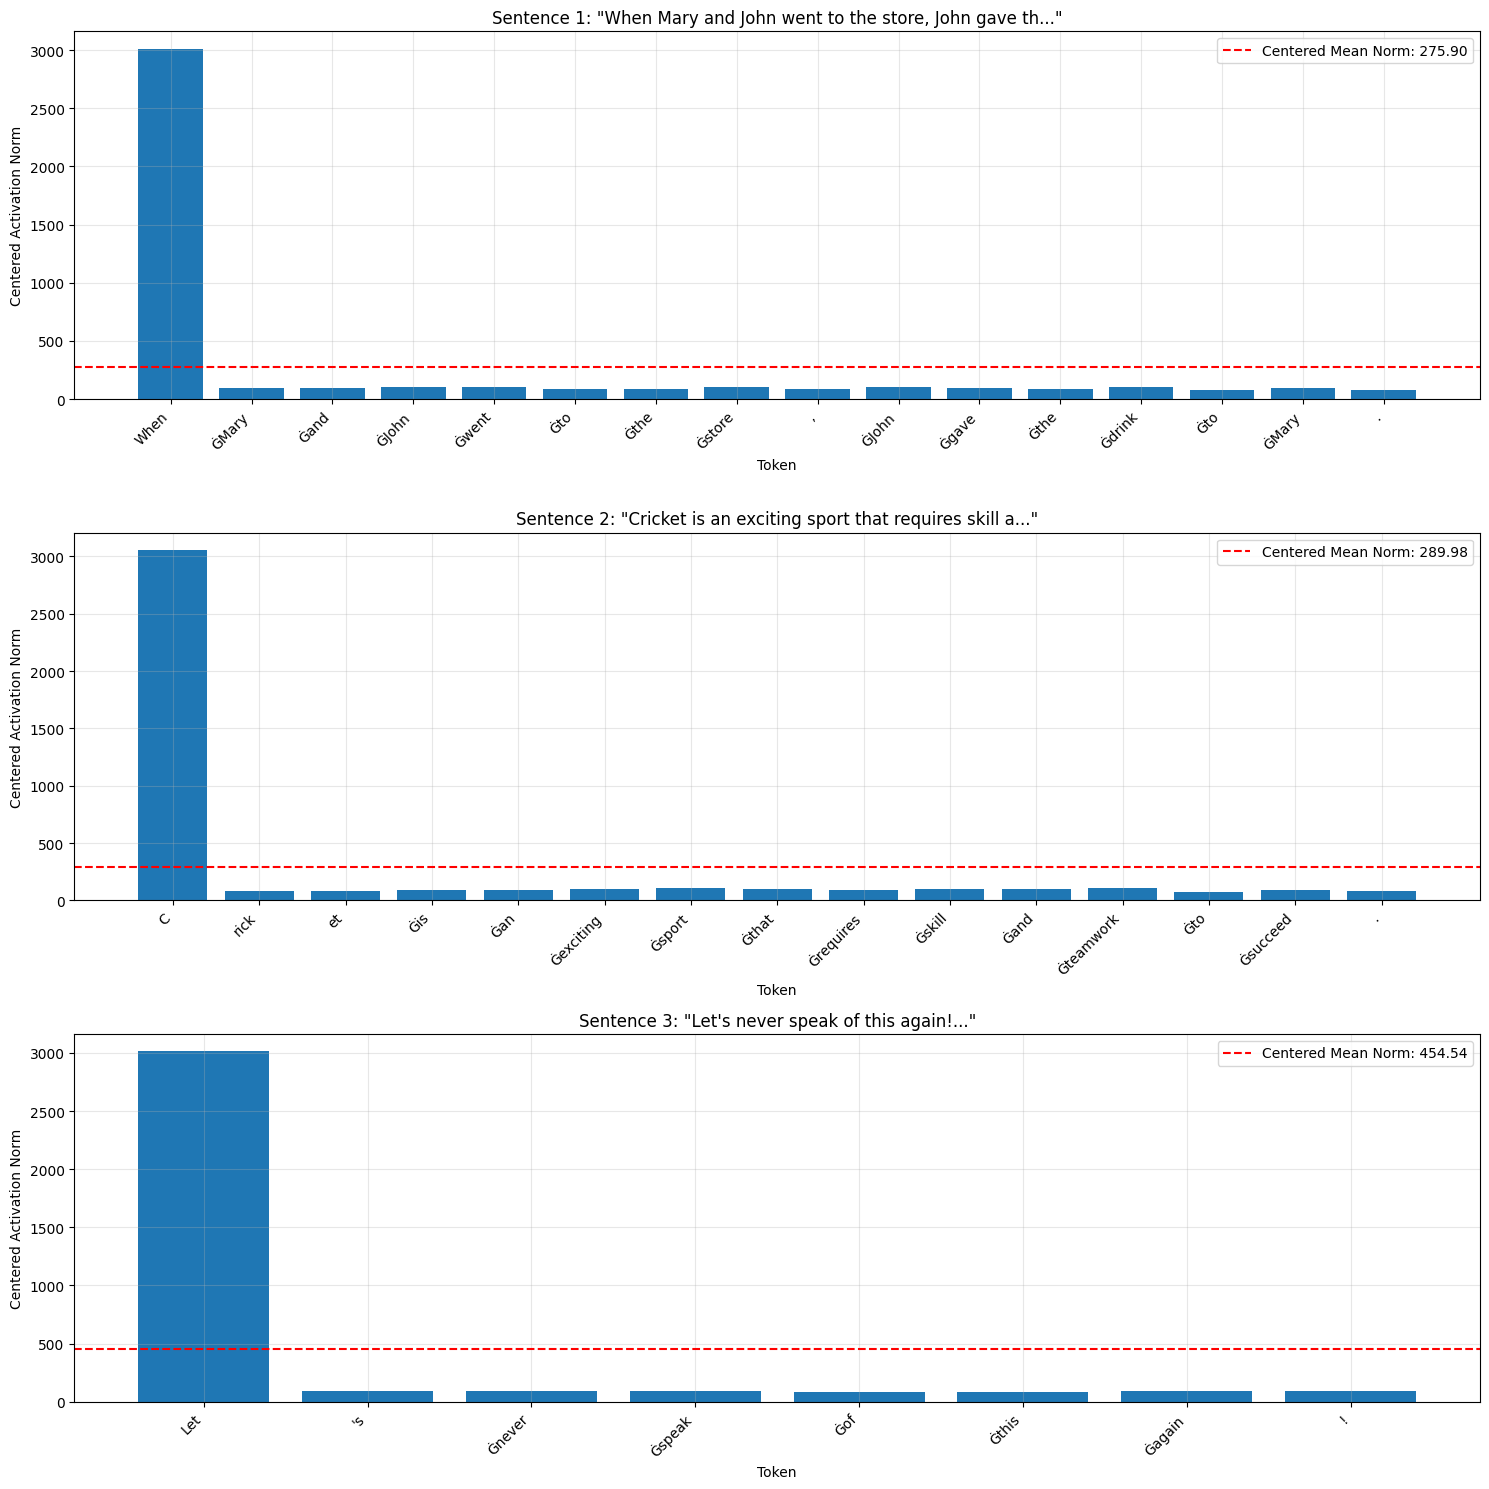

In [87]:
# Example usage:
sample_texts = [
    "When Mary and John went to the store, John gave the drink to Mary.",
    "Cricket is an exciting sport that requires skill and teamwork to succeed.",
    "Let's never speak of this again!"]

token_norms = analyze_activation_norms(sample_texts)

plt.show()